# Delaney Dataset

**ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure**

John S. Delaney

Journal of Chemical Information and Computer Sciences **2004** 44 (3), 1000-1005

DOI: 10.1021/ci034243x

The \( R^2 \) (R-squared) value between the ESOL predicted log solubility and the measured log solubility in the Delaney dataset is approximately \( 0.811 \). This indicates a relatively strong positive correlation between the predicted and measured values. An \( R^2 \) value close to 1 suggests that the ESOL model is fairly accurate in predicting the solubility of the compounds in the dataset.

In [14]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

In [15]:
# # Load the dataset into a Pandas DataFrame
df = pd.read_csv('delaney-processed.csv')

In [16]:
df

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.770,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.330,c1ccsc1
...,...,...,...,...,...,...,...,...,...,...
1123,halothane,-2.608,1,197.381,0,0,0,0.00,-1.710,FC(F)(F)C(Cl)Br
1124,Oxamyl,-0.908,1,219.266,1,0,1,71.00,0.106,CNC(=O)ON=C(SC)C(=O)N(C)C
1125,Thiometon,-3.323,1,246.359,0,0,7,18.46,-3.091,CCSCCSP(=S)(OC)OC
1126,2-Methylbutane,-2.245,1,72.151,0,0,1,0.00,-3.180,CCC(C)C


### Fields in the Delaney Dataset

1. **`Compound ID`:** A unique identifier for each compound in the dataset.
  
2. **`ESOL predicted log solubility in mols per litre`:** The log solubility of the compound as predicted by the ESOL (Estimated SOLubility) model, measured in moles per liter (mols/L).

3. **`Minimum Degree`:** The minimum degree of any atom in the molecular graph of the compound. It represents the least number of edges connected to any vertex in the graph.

4. **`Molecular Weight`:** The molecular weight of the compound, usually measured in g/mol.

5. **`Number of H-Bond Donors`:** The number of hydrogen bond donors present in the compound.

6. **`Number of Rings`:** The number of ring structures present in the compound.

7. **`Number of Rotatable Bonds`:** The number of bonds in the molecule that can be rotated around.

8. **`Polar Surface Area`:** The polar surface area of the molecule, generally measured in square Angstroms (\( \text{Å}^2 \)).

9. **`measured log solubility in mols per litre`:** The experimentally measured log solubility of the compound, measured in moles per liter (mols/L). This is generally considered the 'ground truth' for training and evaluating predictive models.

10. **`smiles`:** The Simplified Molecular Input Line Entry System (SMILES) representation of the compound. It's a string that represents the structural formula of the compound.

This dataset is frequently used for training machine learning models to predict the aqueous solubility of new, untested compounds based on these features.

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 10 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Compound ID                                      1128 non-null   object 
 1   ESOL predicted log solubility in mols per litre  1128 non-null   float64
 2   Minimum Degree                                   1128 non-null   int64  
 3   Molecular Weight                                 1128 non-null   float64
 4   Number of H-Bond Donors                          1128 non-null   int64  
 5   Number of Rings                                  1128 non-null   int64  
 6   Number of Rotatable Bonds                        1128 non-null   int64  
 7   Polar Surface Area                               1128 non-null   float64
 8   measured log solubility in mols per litre        1128 non-null   float64
 9   smiles                        

In [18]:
df.isna().sum()

Compound ID                                        0
ESOL predicted log solubility in mols per litre    0
Minimum Degree                                     0
Molecular Weight                                   0
Number of H-Bond Donors                            0
Number of Rings                                    0
Number of Rotatable Bonds                          0
Polar Surface Area                                 0
measured log solubility in mols per litre          0
smiles                                             0
dtype: int64

In [5]:
# df.info()

# What are we going to use?

In [19]:
df.head()

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


In [21]:
df

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.770,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.330,c1ccsc1
...,...,...,...,...,...,...,...,...,...,...
1123,halothane,-2.608,1,197.381,0,0,0,0.00,-1.710,FC(F)(F)C(Cl)Br
1124,Oxamyl,-0.908,1,219.266,1,0,1,71.00,0.106,CNC(=O)ON=C(SC)C(=O)N(C)C
1125,Thiometon,-3.323,1,246.359,0,0,7,18.46,-3.091,CCSCCSP(=S)(OC)OC
1126,2-Methylbutane,-2.245,1,72.151,0,0,1,0.00,-3.180,CCC(C)C


In [7]:
# df2 = df.drop(['Compound ID', 'smiles', 'ESOL predicted log solubility in mols per litre'], axis=1)

In [22]:
df.columns

Index(['Compound ID', 'ESOL predicted log solubility in mols per litre',
       'Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors',
       'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area',
       'measured log solubility in mols per litre', 'smiles'],
      dtype='object')

In [23]:
df2 = df[
    [
        "Minimum Degree",
        "Molecular Weight",
        "Number of H-Bond Donors",
        "Number of Rings",
        "Number of Rotatable Bonds",
        "Polar Surface Area",
        "measured log solubility in mols per litre",
    ]
]

In [24]:
df2

,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre
0,1,457.432,7,3,7,202.32,-0.770
1,1,201.225,1,2,2,42.24,-3.300
2,1,152.237,0,0,4,17.07,-2.060
3,2,278.354,0,5,0,0.00,-7.870
4,2,84.143,0,1,0,0.00,-1.330
...,...,...,...,...,...,...,...
1123,1,197.381,0,0,0,0.00,-1.710
1124,1,219.266,1,0,1,71.00,0.106
1125,1,246.359,0,0,7,18.46,-3.091
1126,1,72.151,0,0,1,0.00,-3.180


In [25]:
X = df2.drop(['measured log solubility in mols per litre'], axis=1)
y = df2['measured log solubility in mols per litre']

<Axes: >

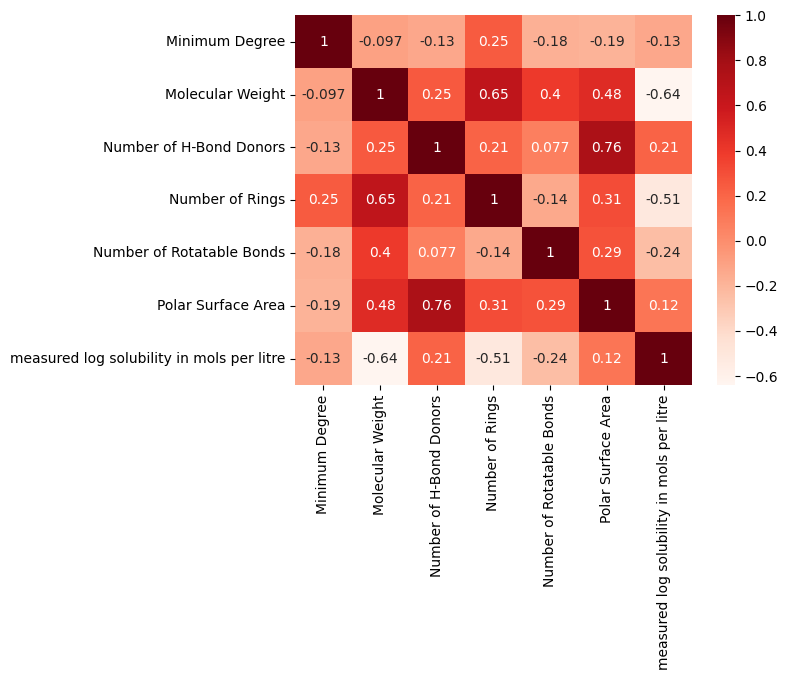

In [31]:
# Geerate correlation heatmap
import seaborn as sns
import matplotlib.pyplot as plt

corr = df2.corr()
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)

In [27]:
y

0      -0.770
1      -3.300
2      -2.060
3      -7.870
4      -1.330
        ...  
1123   -1.710
1124    0.106
1125   -3.091
1126   -3.180
1127   -4.522
Name: measured log solubility in mols per litre, Length: 1128, dtype: float64

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
xgb_model = XGBRegressor(objective='reg:squarederror')

In [33]:
xgb_model.fit(X_train, y_train)

c:\Users\henri\anaconda3\envs\py310w\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\henri\anaconda3\envs\py310w\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\henri\anaconda3\envs\py310w\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\henri\anaconda3\envs\py310w\lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [34]:
y_pred = xgb_model.predict(X_test)

c:\Users\henri\anaconda3\envs\py310w\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\henri\anaconda3\envs\py310w\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\henri\anaconda3\envs\py310w\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\henri\anaconda3\envs\py310w\lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_

In [35]:
# Generate the metrics
print('Mean Squared Error: ', mean_squared_error(y_test, y_pred))
print('Mean Absolute Error: ', mean_absolute_error(y_test, y_pred))
print('R2 Score: ', r2_score(y_test, y_pred))

Mean Squared Error:  0.778312454801333
Mean Absolute Error:  0.5862970916017627
R2 Score:  0.8353406363237822


# Adding Morgan Fingerprints

We go back to our initial dataframe **df**

In [36]:
df.head()

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


In [37]:
# Function to convert SMILES to Morgan fingerprint
def smiles_to_morgan(smiles, radius=2, nBits=1024):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
    return np.array(fp)

In [38]:
# # Generate Morgan fingerprints for each SMILES string
df['Morgan_Fingerprint'] = df['smiles'].apply(smiles_to_morgan)

In [40]:
df.head()

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,Morgan_Fingerprint
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O),"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


In [41]:
# Drop rows where Morgan fingerprints could not be generated
df.dropna(subset=['Morgan_Fingerprint'], inplace=True)

In [42]:
df["Morgan_Fingerprint"]

0       [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...
1       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...
                              ...                        
1123    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1124    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...
1125    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1126    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1127    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: Morgan_Fingerprint, Length: 1128, dtype: object

In [43]:
# Convert Morgan fingerprints from list to separate columns
morgan_df = pd.DataFrame(df['Morgan_Fingerprint'].to_list(), columns=[f'Bit_{i}' for i in range(1024)])

In [44]:
morgan_df

,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,...,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1124,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1125,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1126,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
df['Morgan_Fingerprint'][0].shape

(1024,)

In [ ]:
# morgan_df

In [46]:
# Prepare features and target variable
X = df.drop(columns=['Compound ID', 'ESOL predicted log solubility in mols per litre', 'smiles', 'measured log solubility in mols per litre', 'Morgan_Fingerprint'])

In [47]:
X

,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area
0,1,457.432,7,3,7,202.32
1,1,201.225,1,2,2,42.24
2,1,152.237,0,0,4,17.07
3,2,278.354,0,5,0,0.00
4,2,84.143,0,1,0,0.00
...,...,...,...,...,...,...
1123,1,197.381,0,0,0,0.00
1124,1,219.266,1,0,1,71.00
1125,1,246.359,0,0,7,18.46
1126,1,72.151,0,0,1,0.00


In [48]:
X = pd.concat([X.reset_index(drop=True), morgan_df.reset_index(drop=True)], axis=1)

In [49]:
X

,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,Bit_0,Bit_1,Bit_2,Bit_3,...,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
0,1,457.432,7,3,7,202.32,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,201.225,1,2,2,42.24,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,152.237,0,0,4,17.07,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,2,278.354,0,5,0,0.00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,84.143,0,1,0,0.00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,1,197.381,0,0,0,0.00,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1124,1,219.266,1,0,1,71.00,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1125,1,246.359,0,0,7,18.46,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1126,1,72.151,0,0,1,0.00,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
y = df['measured log solubility in mols per litre']

In [ ]:
# X

In [52]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
X_test

,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,Bit_0,Bit_1,Bit_2,Bit_3,...,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
1091,1,70.135,0,0,1,0.00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
898,1,224.260,2,1,3,75.27,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
739,1,216.668,1,1,0,54.86,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
140,1,70.135,0,0,1,0.00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1019,1,320.046,0,2,3,0.00,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,2,168.195,0,3,0,13.14,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
429,1,490.639,0,6,0,17.07,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,1,70.135,0,0,2,0.00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1036,1,238.287,2,1,3,75.27,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


In [54]:
# Initialize and train the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror')
xgb_model.fit(X_train, y_train)

c:\Users\henri\anaconda3\envs\py310w\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\henri\anaconda3\envs\py310w\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\henri\anaconda3\envs\py310w\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\henri\anaconda3\envs\py310w\lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [55]:
# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

c:\Users\henri\anaconda3\envs\py310w\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\henri\anaconda3\envs\py310w\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\henri\anaconda3\envs\py310w\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\henri\anaconda3\envs\py310w\lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_

In [56]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [57]:
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")

Mean Squared Error: 0.5667539773964773
Root Mean Squared Error: 0.7528306432368951
Mean Absolute Error: 0.537258898357803
R2 Score: 0.8800978338411787


In [58]:
# Create a DataFrame to compare true and predicted values
comparison_df = pd.DataFrame({'True_Values': y_test, 'Predictions': y_pred})

# Reset the index for better visualization
comparison_df.reset_index(drop=True, inplace=True)

# Display the comparison DataFrame
print(comparison_df.head(10))

   True_Values  Predictions
0       -2.540    -2.308763
1       -2.253    -1.768214
2       -2.484    -2.789654
3       -2.540    -2.308763
4       -7.200    -7.112064
5       -1.190    -0.652263
6       -4.314    -3.587688
7       -2.190    -1.988119
8       -7.660    -8.661954
9       -2.570    -3.215421


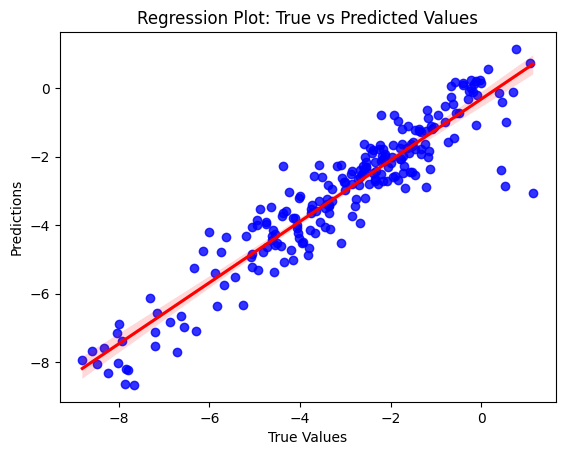

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the regression plot
sns.regplot(x=y_test, y=y_pred, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Regression Plot: True vs Predicted Values')
plt.show()


# Saving the model for later

In [ ]:
# # Save the model

# xgb_model.save_model('xgb_model.json')